## Introduction

In this example, we look into what sort of visual patterns image classification models
learn. We'll be using the `ResNet50V2` model, trained on the ImageNet dataset.

Our process is simple: we will create input images that maximize the activation of
specific filters in a target layer. Such images represent a visualization of the
pattern that the filter responds to.

## Setup

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


# The dimensions of our input image
img_width = 180
img_height = 180
# Our target layer: we will visualize the filters from this layer.
# See `model.summary()` for list of layer names, if you want to change this.
#layer_name = "conv3_block4_out"

## Build a feature extraction model

In [37]:
# Build a ResNet50V2 model loaded with pre-trained ImageNet weights
model = keras.applications.ResNet50V2(weights="imagenet", include_top=False)
model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                      

The goal of this notebook is to visualize the learned patterns in layers starting from first level layers to deep layers.

In [35]:
#the names of the layers to be considered
layers=['conv1_conv','conv2_block1_3_conv','conv3_block1_3_conv','conv4_block1_2_conv','conv5_block3_3_conv']

In [4]:
#to every layer we associate its feature extractor
features={}
for l in layers:
  layer = model.get_layer(name=l)
  features[l]=keras.Model(inputs=model.inputs, outputs=layer.output)

## Set up the gradient ascent process

The "loss" we will maximize is simply the mean of the activation of a specific filter in
our target layer. To avoid border effects, we exclude border pixels.

In [5]:
def compute_loss(input_image, filter_index,feature_extractor):#########
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)


Our gradient ascent function simply computes the gradients of the loss above
with regard to the input image, and update the update image so as to move it
towards a state that will activate the target filter more strongly.

In [6]:

@tf.function
def gradient_ascent_step(img, filter_index, learning_rate,feature_extractor):#######
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index,feature_extractor)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img


## Set up the end-to-end filter visualization loop

Our process is as follow:

- Start from a random image that is close to "all gray" (i.e. visually neutral)
- Repeatedly apply the gradient ascent step function defined above
- Convert the resulting input image back to a displayable form, by normalizing it,
center-cropping it, and restricting it to the [0, 255] range.

In [7]:

def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, img_width, img_height, 3))
    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.375, +0.125]
    return (img - 0.5) * 0.25


def visualize_filter(filter_index,feature_extractor):####################""
    # We run gradient ascent for 20 steps
    iterations = 20
    learning_rate = 10
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate,feature_extractor)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img


def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img


Let's try it out with filter 0 in the target layers:

conv1_conv


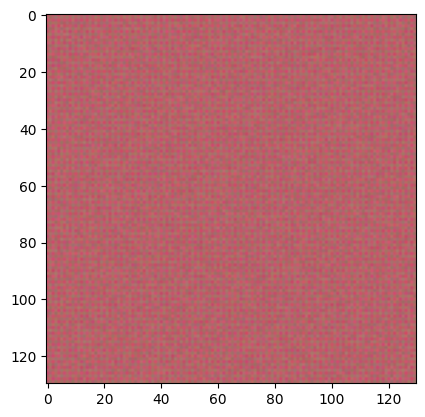

conv2_block1_3_conv


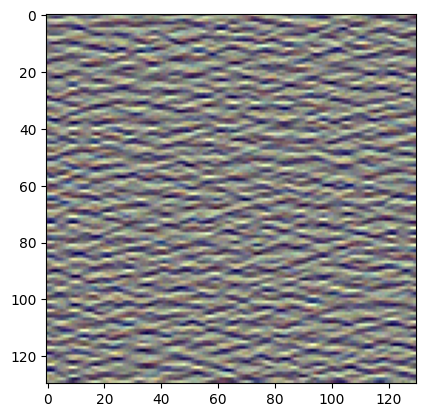

conv3_block1_3_conv


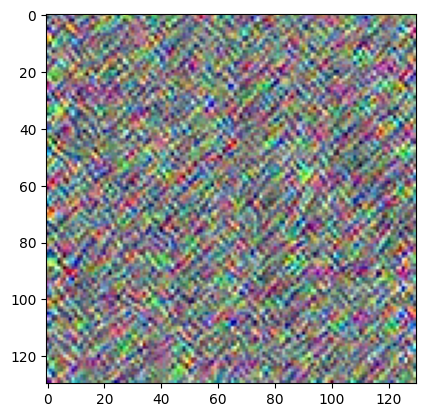

conv4_block1_2_conv


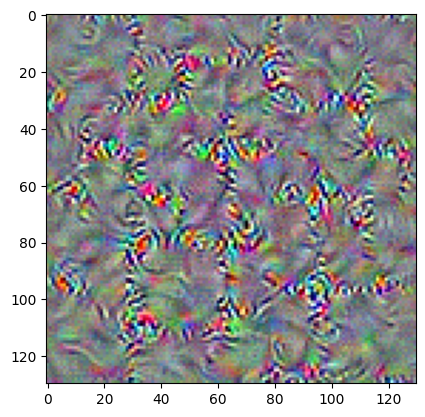

conv5_block3_3_conv


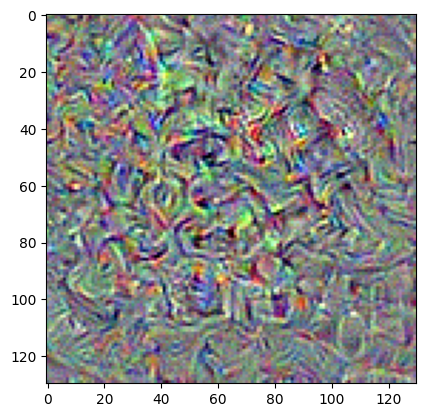

In [8]:
from IPython.display import Image, display



for layer_name in layers:
  # Set up a model that returns the activation values for our target layer
  #layer = model.get_layer(name=layer_name)
  #feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)
  #############""
  loss, img = visualize_filter(16,features[layer_name])
  print(layer_name)
  plt.imshow(img)
  plt.show()
  #keras.utils.save_img("0.png", img)
  #display(Image("0.png"))

#keras.utils.save_img("0.png", img)

The showed images represent the inputs that maximize the response of filter 0 in the target layers

We can play with the filter index and learn more patterns

We remark that the deeper is the location of the layer in the neural network the more complex is the learnt pattern: the first layers learn the direction and color, the following layers learn more complicated textures.

Image classification models see the world by decomposing their inputs over a "vector
basis" of texture filters such as these.

See also
[this old blog post](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html)
for analysis and interpretation.

# Application: output class (340, zebra)

Let's try this out on the output class "zebra" and see which representations do maximize the response of the filters to zebra output probability

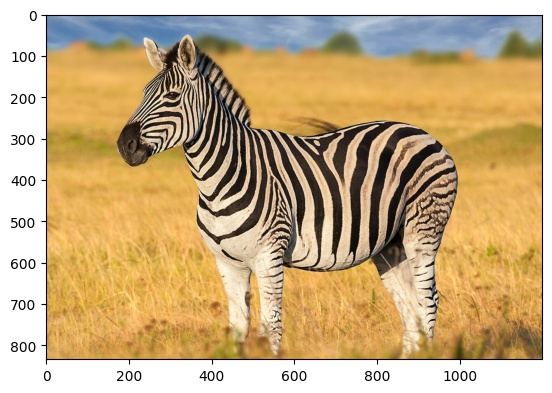

In [10]:
img=plt.imread('/content/zebra.jpg')
plt.imshow(img)

In [38]:
img.shape

(784, 1150, 3)

In [39]:
def initialize_image():
    # We start from a gray image with some random noise
    # img = tf.random.uniform((1, img_width, img_height, 3))
    img=plt.imread('/content/zebra.jpg')
    img=img.reshape((1,img.shape[0],img.shape[1],3))
    img=img/255.0
    img=img.astype("uint8")
    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.375, +0.125]
    return (img - 0.5) * 0.25

In [40]:

def visualize_filter(filter_index,feature_extractor):####################""
    # We run gradient ascent for 20 steps
    iterations = 20
    learning_rate = 10
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate,feature_extractor)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img


def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img


Let's try it out with filter 0 in the target layers:

conv1_conv


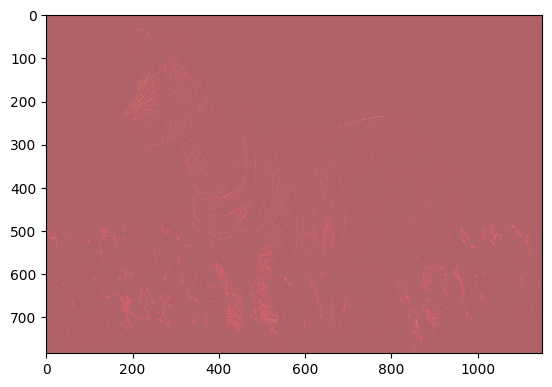

conv2_block1_3_conv


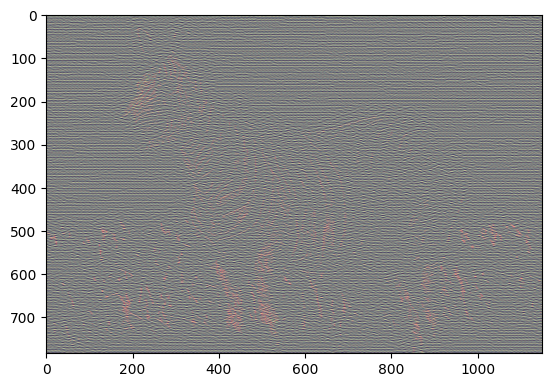

conv3_block1_3_conv


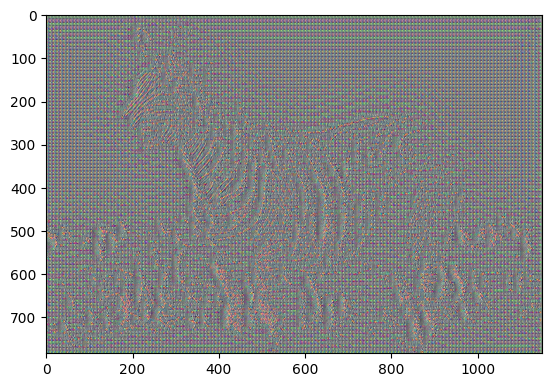

conv4_block1_2_conv


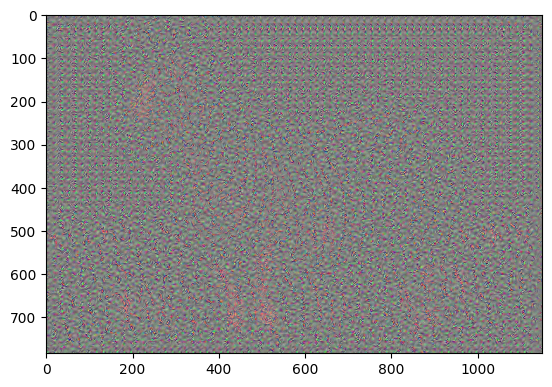

conv5_block3_3_conv


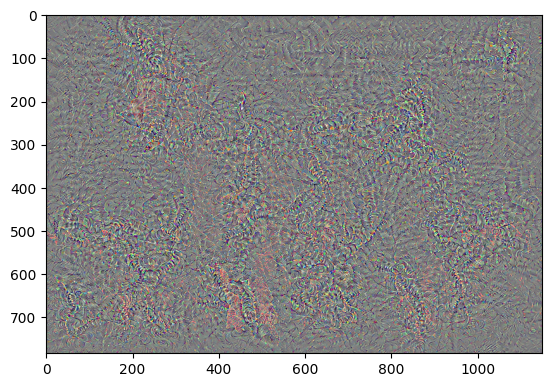

In [41]:
from IPython.display import Image, display



for layer_name in layers:
  # Set up a model that returns the activation values for our target layer
  #layer = model.get_layer(name=layer_name)
  #feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)
  #############""
  loss, img = visualize_filter(16,features[layer_name])
  print(layer_name)
  plt.imshow(img)
  plt.show()
  #keras.utils.save_img("0.png", img)
  #display(Image("0.png"))

#keras.utils.save_img("0.png", img)

We can see that the first two layers learn linear patterns (lines covering zebra's skin) and the deeper layers tend to learn non-linear and more complex patterns.

# References:


*   https://keras.io/examples/vision/visualizing_what_convnets_learn/
*   https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

